<a href="https://colab.research.google.com/github/ProfPaiMau/EmbAIProj1/blob/main/EmbeddedAIOCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pytesseract
!apt-get install -y tesseract-ocr


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 49 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 1s (9,153 kB/s)
Selecting previously unselected package tesseract-ocr-eng.
(Reading database ... 123623 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-

In [ ]:
# Generic Libraries
%matplotlib inline
from PIL import Image
import os
import pandas as pd
import numpy as np
import re,string,unicodedata

#Tesseract Library
import pytesseract

#Warnings
import warnings
warnings.filterwarnings("ignore")

#Garbage Collection
import gc

#Gensim Library for Text Processing
import gensim.parsing.preprocessing as gsp
from gensim import utils

#TextBlob Library (Sentiment Analysis)
from textblob import TextBlob, Word

#Plotting Libraries
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.image as mpimg
import cv2

In [37]:
def extractTextFrom(directory,num = 1):
    i = 0;
    print ("Extraindo texto")
    for subdir, dirs, files in os.walk(directory):
        for file in files:
            # Analisar 3 primeiras imagens definidas pelo num
            if i >= num:
                break
            filepath = subdir + os.sep + file
            print ("Analisando ficheiro " +  filepath)

            image = Image.open(filepath)
            image.show()

            plt.figure(figsize=(12,8))
            im = cv2.imread(filepath)
            im_resized = cv2.resize(im, (1200, 800), interpolation=cv2.INTER_LINEAR)

            plt.imshow(cv2.cvtColor(im_resized, cv2.COLOR_BGR2RGB))
            plt.show()

            text = pytesseract.image_to_string(Image.open(filepath), timeout=5)
            print(text)

            i = i + 1

            return text

In [45]:
import difflib

def calc_precisao(extracted_text, expected_text_file):

    with open(expected_text_file, 'r') as file:
        expected_text = file.read().strip()

    matcher = difflib.SequenceMatcher(None, extracted_text, expected_text)

    print(f"Precisao --> {matcher.ratio() * 100:.2f}%")


Extraindo texto
Analisando ficheiro /content/Test1/AccuracyTest.JPG


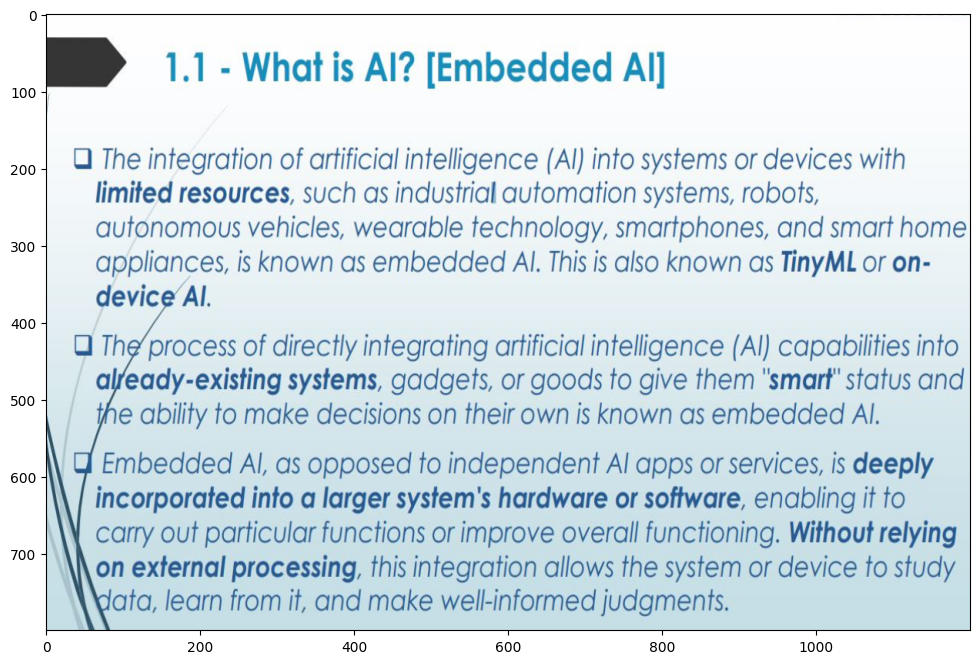

2D 1.1 - Whatis Al? [Embedded Al]

Q The integration of artificial intelligence (Al) into systems or devices with
limited resources, such as industrial automation systems, robots,
autonomous vehicles, wearable technology, smartphones, and smart home
appliances, is known as embedded Al. This is also Known as TinyML or on-

device“Al.
QO) The’process of directly integrating artificial intelligence (Al) capabilities into
alfeady-existing systems, gadgets, or goods to give them "smart" status and
e ability to make decisions on their own is known as embedded Al.

Embedded Al, as opposed to independent Al apps or services, is deeply
incorporated into a larger system's hardware or software, enabling it to
carry out particular functions or improve overall functioning. Without relying
on external processing, this integration allows the system or device to study
lata, learn from it, and make well-informed judgments.

 
   
 
 
 
 

 

Precisao --> 43.88%


In [46]:
texto = extractTextFrom('/content/Test1')

calc_precisao(texto, '/content/Test1Expected/referencia.txt')